In [7]:
%cd bci_eeg/courses/signal_processing/4.filtering
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

A:\AI\bci_eeg\courses\signal_processing\4.filtering


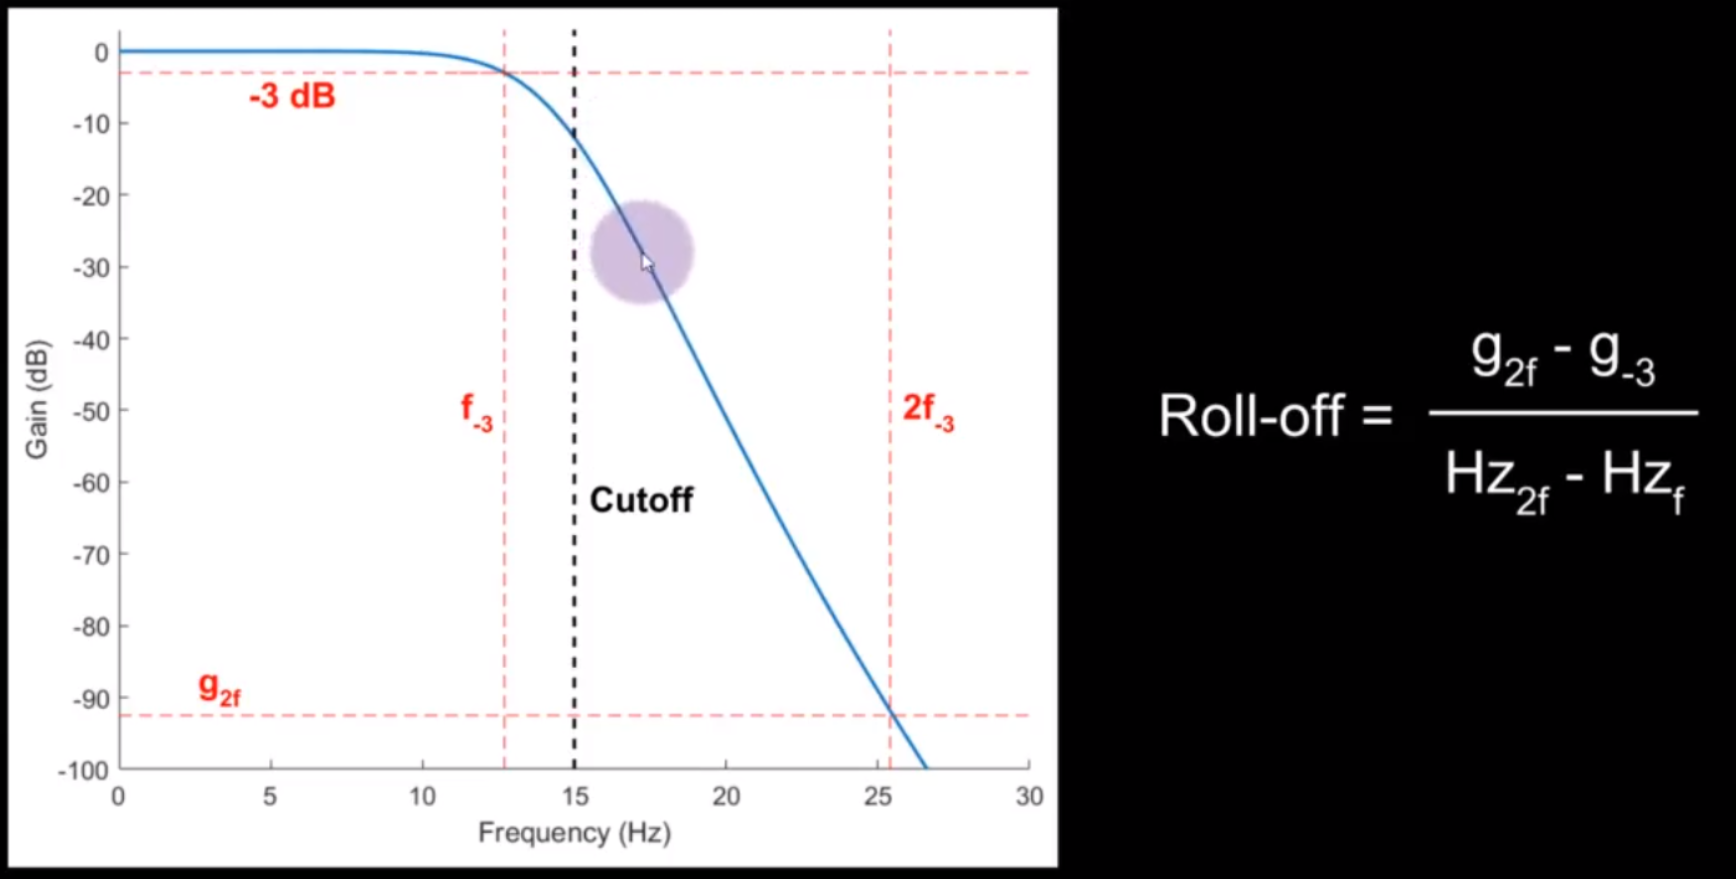

In [16]:
from IPython.display import Image
Image(filename='roll_off_formula.png') 


# Windowed sinc filter


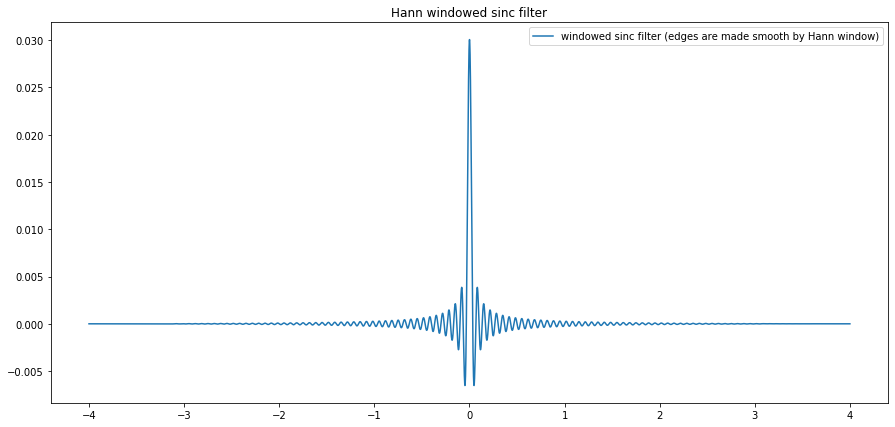

In [53]:
# WINDOWED SINC FILTER

sampling_rate = 1000
time_axis = np.arange(-4, 4, float(1 / sampling_rate))
n_windowed_filter = len(time_axis)  #order

frequency_cutoff = 15  # Hz
sinc_filter = np.sin(2 * np.pi * frequency_cutoff * time_axis) / time_axis  # at time 0 there is a zero division

# adjusting filter so there are no NaN values after division by zero
sinc_filter[~np.isfinite(sinc_filter)] = np.max(sinc_filter)
# Normalization to unit-gain
sinc_filter /= sum(sinc_filter)

# Windowing by Hanning window
sinc_filter_windowed = sinc_filter * np.hanning(n_windowed_filter)

plt.figure(figsize=(15, 7))
plt.plot(time_axis, sinc_filter_windowed, label='windowed sinc filter (edges are made smooth by Hann window)')
plt.legend()
plt.title('Hann windowed sinc filter')
plt.show()


# Butterworth filter

Text(0.5, 1.0, 'Filtering an impulse')

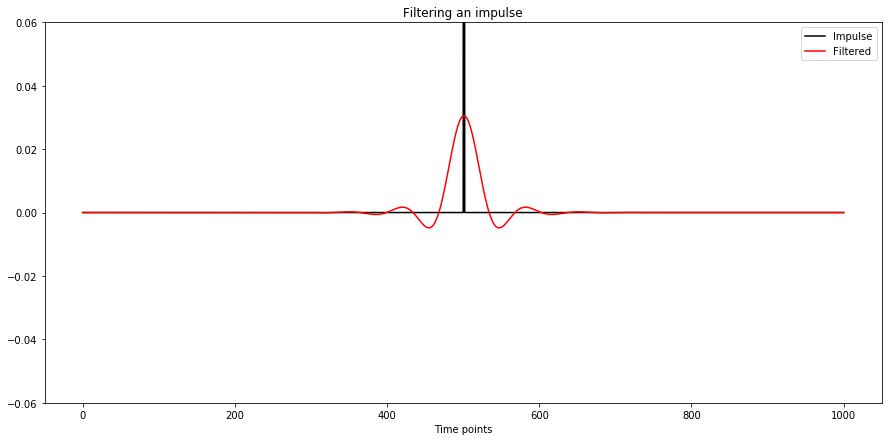

In [54]:
# BUTTERWORTH FILTER
nyquist_rate = sampling_rate / 2
order = 5  # very small compared to FIR filters

coef_kernel_B, coef_kernel_A = signal.butter(order, frequency_cutoff / nyquist_rate, btype='low')
# Testing on an impulse
impulse_signal = np.zeros(1001)
impulse_signal[501] = 1
filtered_signal = signal.filtfilt(coef_kernel_B, coef_kernel_A, impulse_signal)

# plot
plt.figure(figsize=(15, 7))
plt.plot(impulse_signal, 'k', label='Impulse')
plt.plot(filtered_signal, 'r', label='Filtered')
plt.ylim([-.06, .06])
plt.legend()
plt.xlabel('Time points')
plt.title('Filtering an impulse')


# Calculating roll-off of these filters

Text(0, 0.5, 'Gain (dB)')

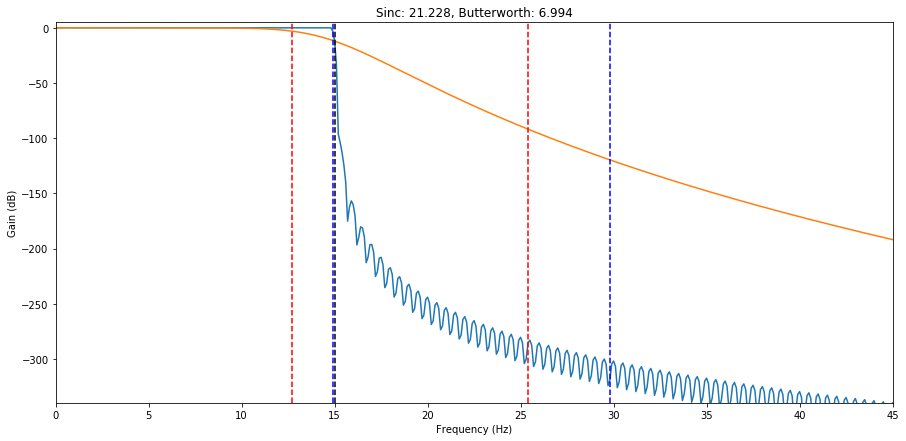

In [58]:
# CALCULATING ROLL-OFF OF THESE FILTERS
n_fft = 10000
hz = np.linspace(0, nyquist_rate, int(np.floor(n_fft / 2) + 1))

sinc_filter_windowed_power = 20 * np.log10(np.abs(np.fft.fft(sinc_filter_windowed, n=n_fft)) ** 2)
sinc_filter_windowed_power = sinc_filter_windowed_power[:len(hz)]
butterworth_filter_power = 20 * np.log10(np.abs(np.fft.fft(filtered_signal, n_fft)) ** 2)
butterworth_filter_power = butterworth_filter_power[:len(hz)]

plt.figure(figsize=(15, 7))
plt.plot(hz, sinc_filter_windowed_power)
plt.plot(hz, butterworth_filter_power)

plotedge = int(np.argmin((hz - frequency_cutoff * 3) ** 2))
plt.xlim([0, frequency_cutoff * 3])
min_y = np.min((butterworth_filter_power[plotedge], sinc_filter_windowed_power[plotedge]))
plt.ylim([min_y, 5])
plt.plot([frequency_cutoff, frequency_cutoff], [min_y, 5], 'k--')

# find -3 dB after filter edge
filtcut_idx = np.min((hz - frequency_cutoff) ** 2)

sincX3db = np.argmin((sinc_filter_windowed_power - -3) ** 2)
butterX3db = np.argmin((butterworth_filter_power - -3) ** 2)

# add to the plot
plt.plot([hz[sincX3db], hz[sincX3db]], [min_y, 5], 'b--')
plt.plot([hz[butterX3db], hz[butterX3db]], [min_y, 5], 'r--')

# find double the frequency
sincXoct = np.argmin((hz - hz[sincX3db] * 2) ** 2)
butterXoct = np.argmin((hz - hz[butterX3db] * 2) ** 2)

# add to the plot
plt.plot([hz[sincXoct], hz[sincXoct]], [min_y, 5], 'b--')
plt.plot([hz[butterXoct], hz[butterXoct]], [min_y, 5], 'r--')

# find attenuation from that point to double its frequency
sincXatten = sinc_filter_windowed_power[sincX3db * 2]
butterXatten = butterworth_filter_power[butterX3db * 2]

sincXrolloff = (sinc_filter_windowed_power[sincX3db] - sinc_filter_windowed_power[sincXoct]) / (
        hz[sincXoct] - hz[sincX3db])
butterXrolloff = (butterworth_filter_power[butterX3db] - butterworth_filter_power[butterXoct]) / (
        hz[butterXoct] - hz[butterX3db])

# report!
plt.title('Sinc: %.3f, Butterworth: %.3f' % (sincXrolloff, butterXrolloff))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
